## ECSE 415, Assignment 2 / part 3



## 3 Object Detection
  Trainig: 
  
    -Resize the training images to 128 × 128.
    -Compute HoG features using cell size of 4 × 4 pixels, block size of 2 × 2 cells and 9 orientation bins.
    -Calculate and store the mean feature map across training images. 
    -Repeat above steps for training images flipped around vertical axis.
    -Display 9 orientation channels of the mean feature maps for the first block. 
    
  Testing:
  
    -Extract overlapping windows from the test image. Details on the size of the window and the stride are given  
     below.
    -Resize windows to 128 × 128 and Compute HoG features similar to what was done during training. 
    -Compute the euclidean distance between the feature map of each win- dow and the mean feature map of training  
     images. Repeat the same with the mean feature map of flipped training images.
    -Threshold the two distances to detect cars in the test image. Display detected window. 
    -Experiment with size of the window, stride and the detection thresh- old to achieve accuracy.
 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
#Training

#list of test images
images = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
flip_images = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#Load images 
images[0] = cv2.cvtColor(cv2.imread("car1.jpg"), cv2.COLOR_BGR2RGB)
images[1] = cv2.cvtColor(cv2.imread("car2.jpg"), cv2.COLOR_BGR2RGB)
images[2] = cv2.cvtColor(cv2.imread("car3.jpg"), cv2.COLOR_BGR2RGB)
images[3] = cv2.cvtColor(cv2.imread("car4.jpg"), cv2.COLOR_BGR2RGB)
images[4] = cv2.cvtColor(cv2.imread("car5.jpg"), cv2.COLOR_BGR2RGB)
images[5] = cv2.cvtColor(cv2.imread("car6.jpg"), cv2.COLOR_BGR2RGB)
images[6] = cv2.cvtColor(cv2.imread("car7.jpg"), cv2.COLOR_BGR2RGB)
images[7] = cv2.cvtColor(cv2.imread("car8.jpg"), cv2.COLOR_BGR2RGB)
images[8] = cv2.cvtColor(cv2.imread("car9.jpg"), cv2.COLOR_BGR2RGB)
images[9] = cv2.cvtColor(cv2.imread("car10.jpg"), cv2.COLOR_BGR2RGB)
images[10] = cv2.cvtColor(cv2.imread("car11.jpg"), cv2.COLOR_BGR2RGB)
images[11] = cv2.cvtColor(cv2.imread("car12.jpg"), cv2.COLOR_BGR2RGB)
images[12] = cv2.cvtColor(cv2.imread("car13.jpg"), cv2.COLOR_BGR2RGB)
images[13] = cv2.cvtColor(cv2.imread("car14.jpg"), cv2.COLOR_BGR2RGB)

# Resize images
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (128, 128)) 
    

In [3]:
# Computing HoG features
def hog(images, cell_size = (4, 4), block_size = (2, 2), nbins = 9):
    hog_cal_list = []
    
    for img in images:
        # create HoG Object
        # winSize is the size of the image cropped to multiple of the cell size
        # all arguments should be given in terms of number of pixels
        hog = cv2.HOGDescriptor(_winSize=(128 // cell_size[1] * cell_size[1],
                                          128 // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        n_cells = (128 // cell_size[0], 128 // cell_size[1])

        # Compute HoG features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[1], block_size[0], nbins) \
                       .transpose((1, 0, 3, 2, 4))  # index blocks by rows first

        hog_cal_list.append(hog_feats)
        
    return hog_cal_list


In [4]:
# Calculating and storing mean feature map
sum_feat = 0
hog_feat_mean = hog(images)

for feat_value in hog_feat_mean:
    sum_feat += feat_value

mean_feat_val = sum_feat / 14



In [5]:
# Flip car images and do the same steps as previous parts
flip_images = np.flip(images, -2)
    
sum_feat_flip = 0
hog_feat_mean_flip = hog(flip_images)

for feat_value_flip in hog_feat_mean_flip:
    sum_feat_flip += feat_value_flip

mean_feat_val_flip = sum_feat_flip / 14


First 9 figures for unflipped images, second half for flipped ones.


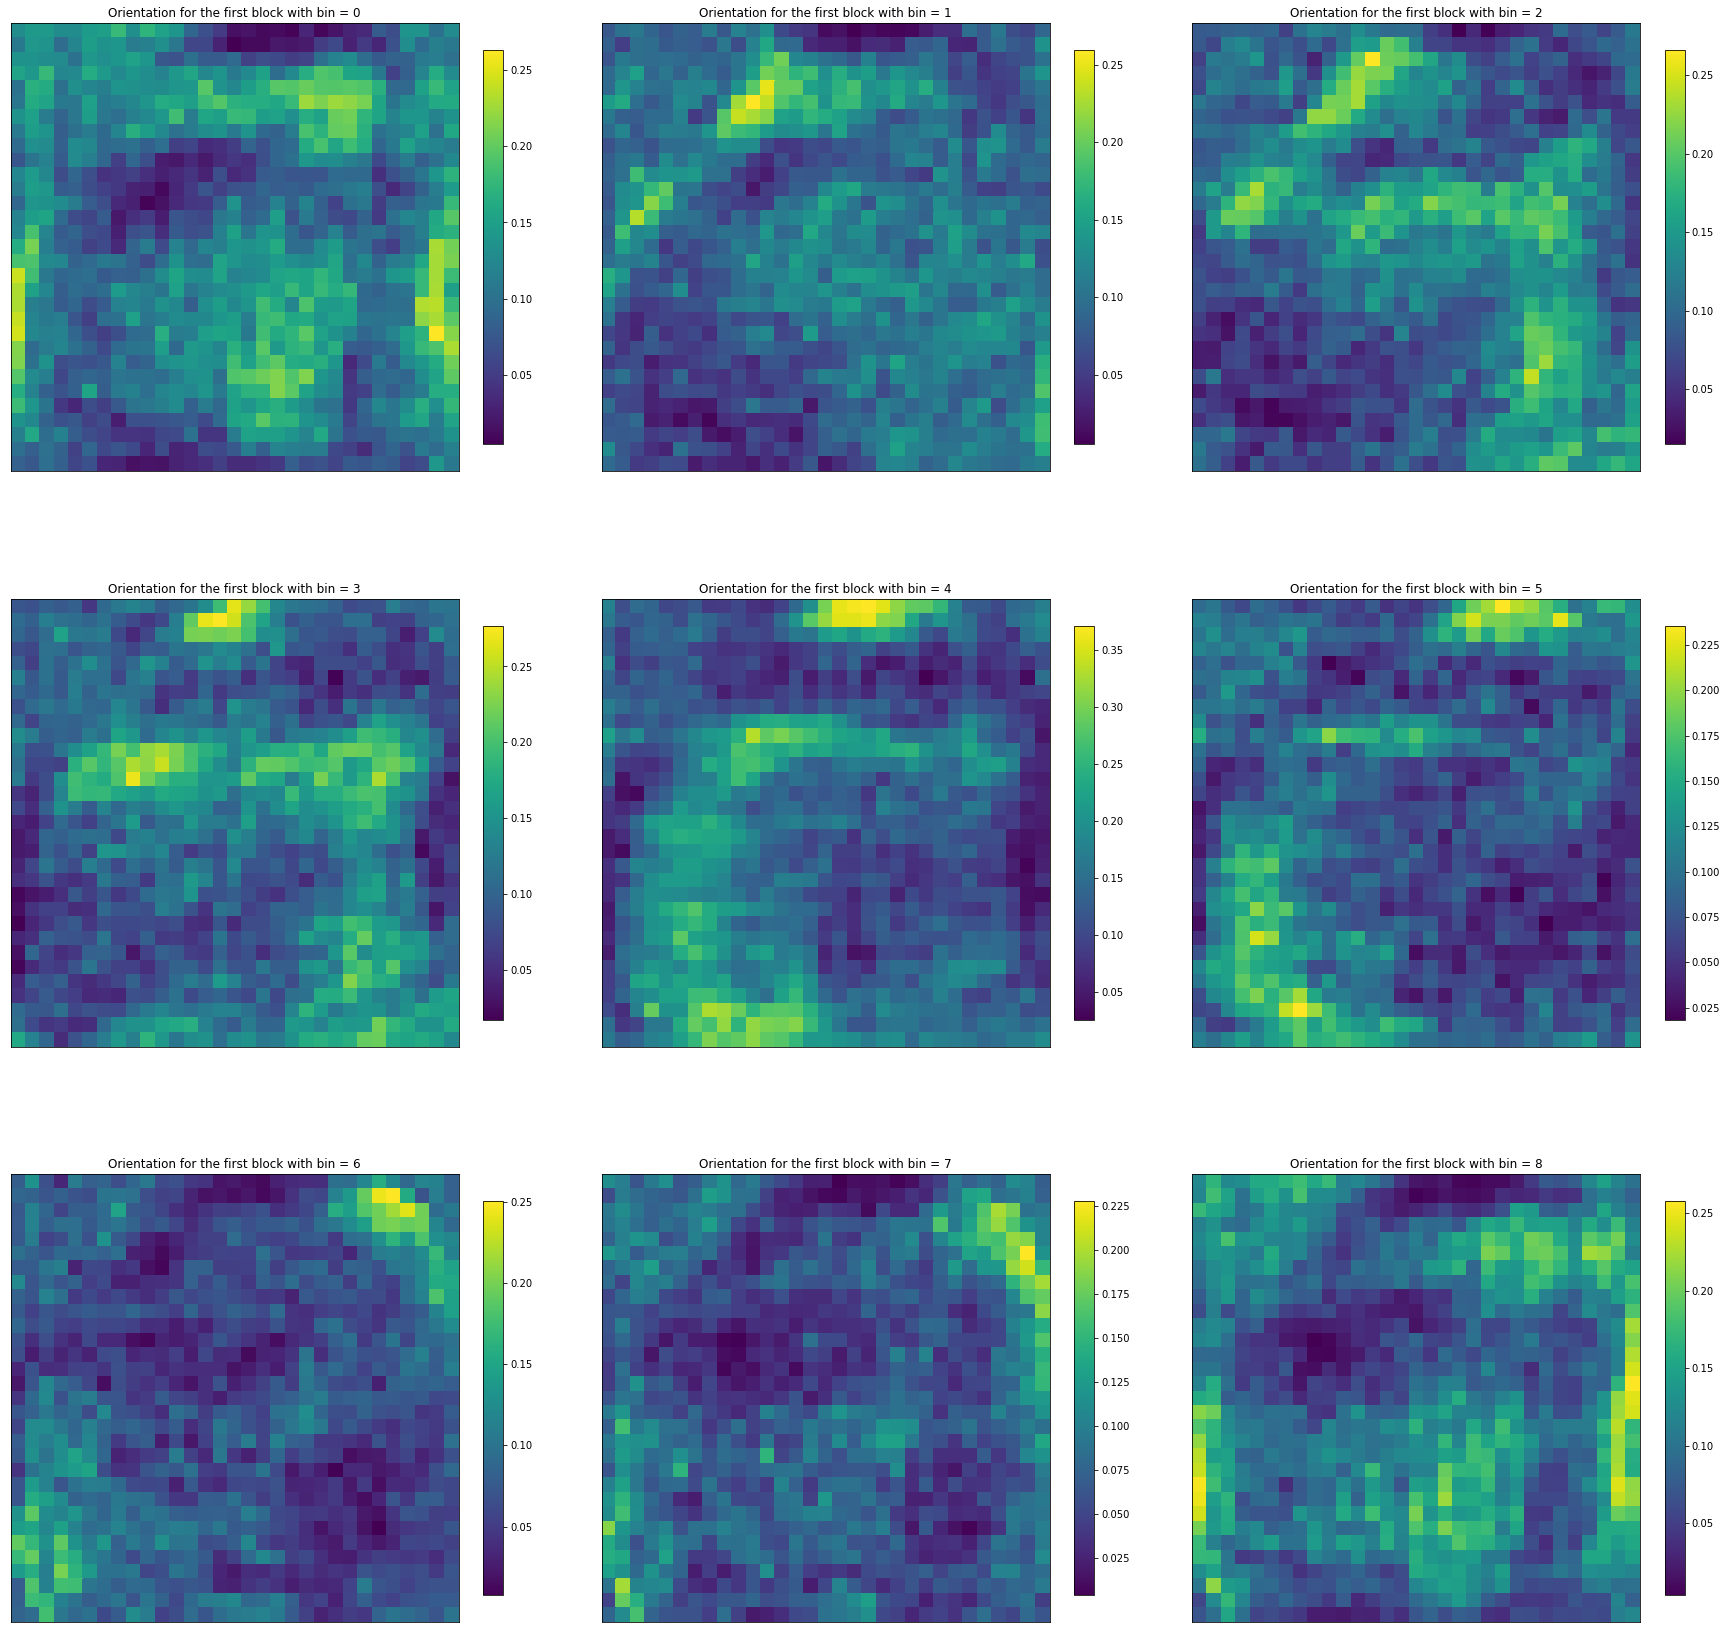

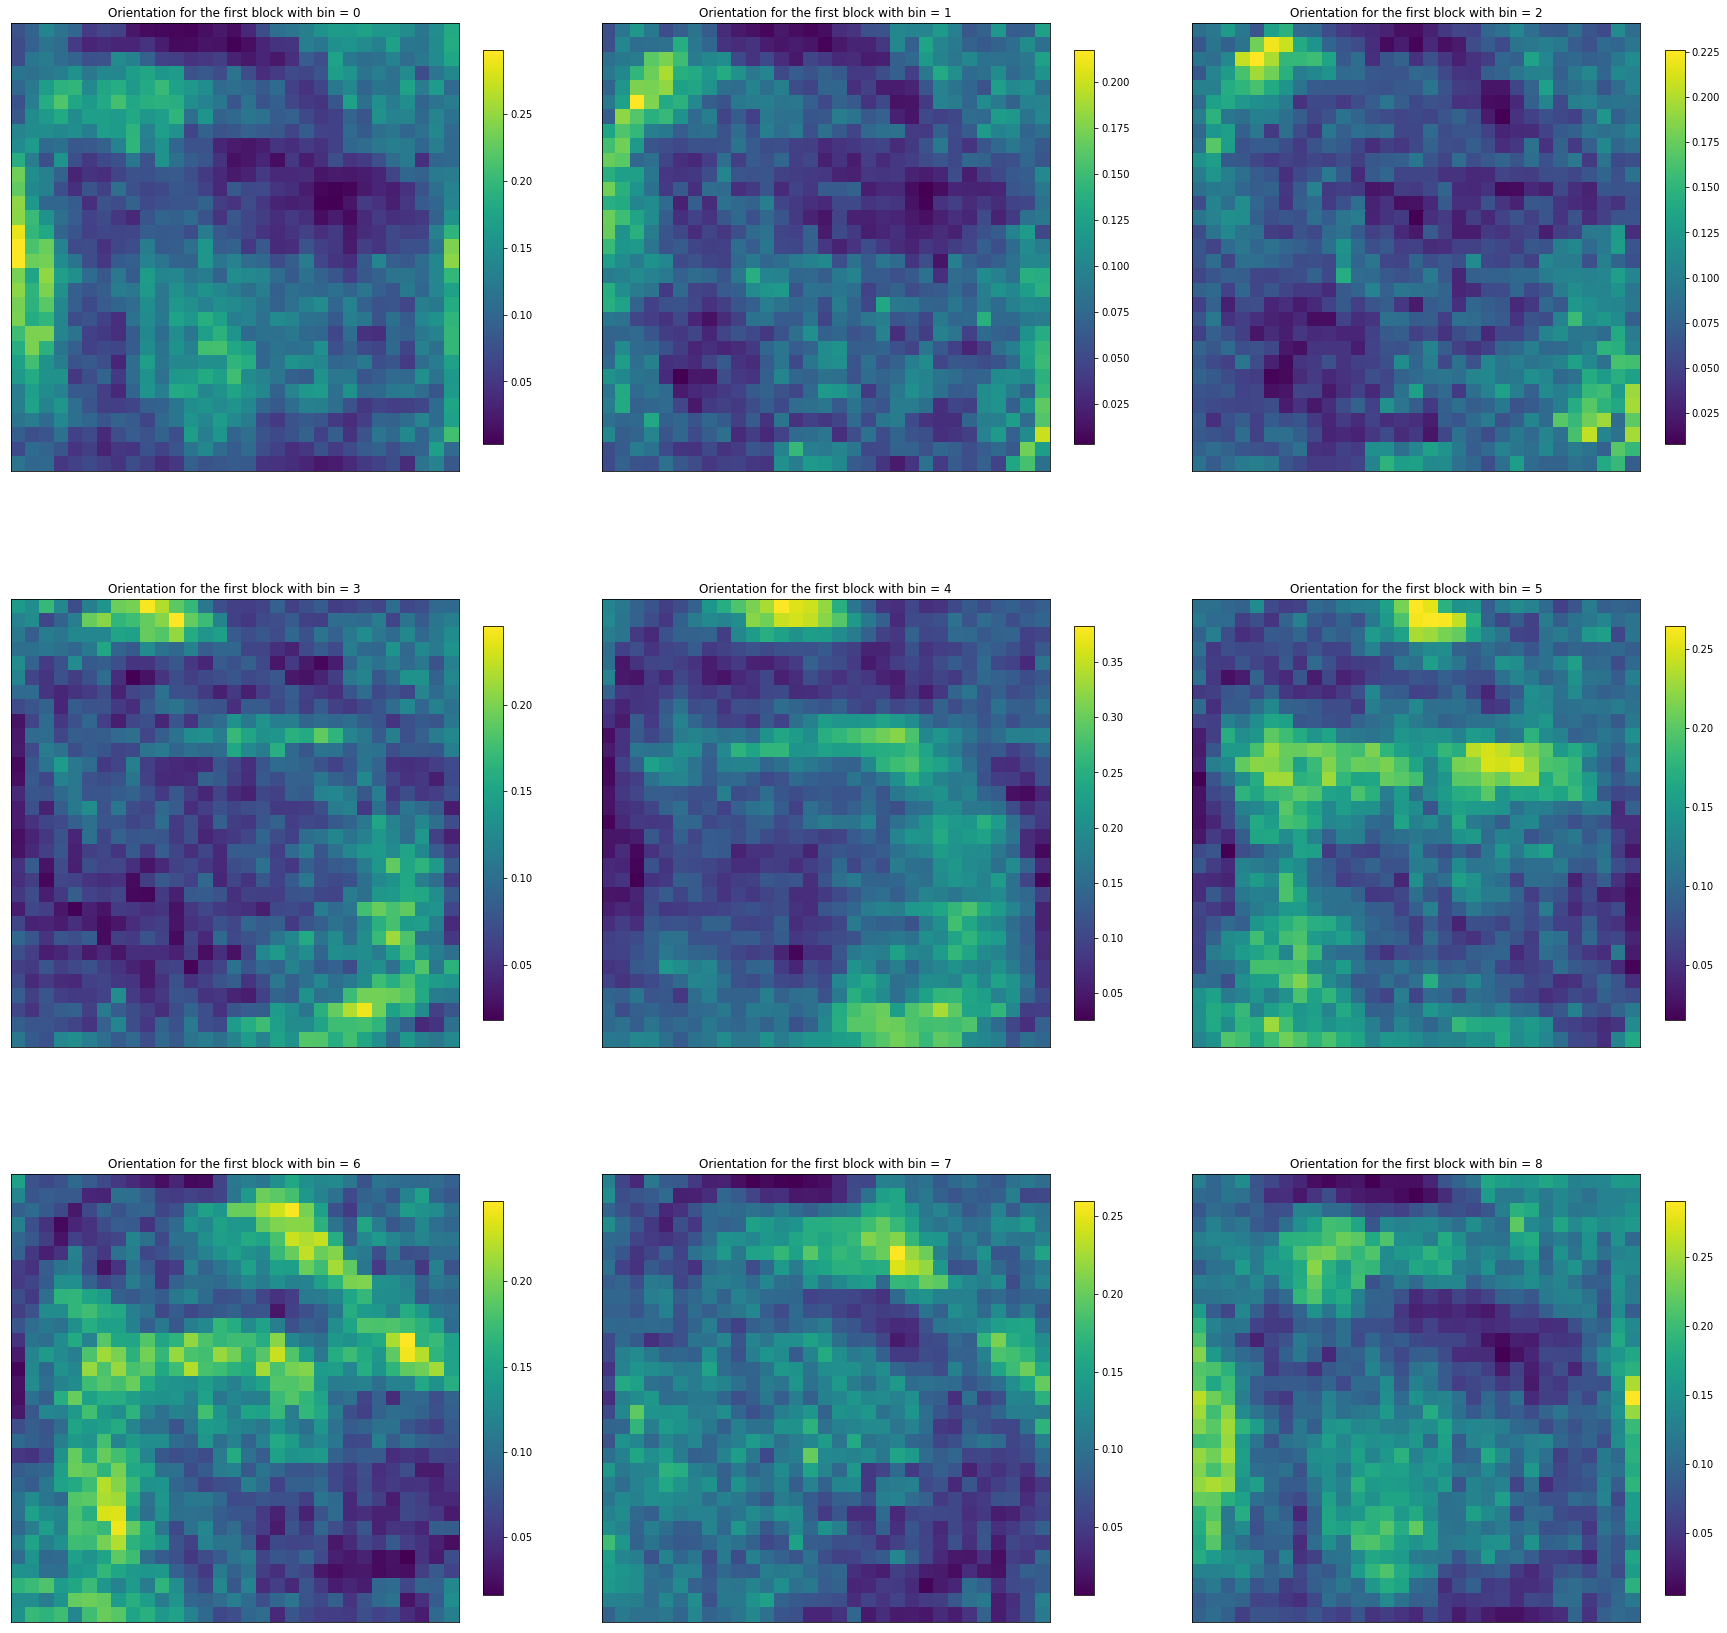

In [6]:
# Displaying 9 orientation channels

def dis_mean_hog (mean_feat_val):
    plt.figure(figsize = (30,30))
    for i in range(9):
        plt.subplot(331 + i)
        plt.pcolor(mean_feat_val[:, :, 0, 0, i])
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("Orientation for the first block with bin = " + str(i))
        plt.xticks([]), plt.yticks([])
        plt.colorbar(fraction = 0.04) 
    
# Display    
print("First 9 figures for unflipped images, second half for flipped ones.")
dis_mean_hog(mean_feat_val) 
dis_mean_hog(mean_feat_val_flip) 




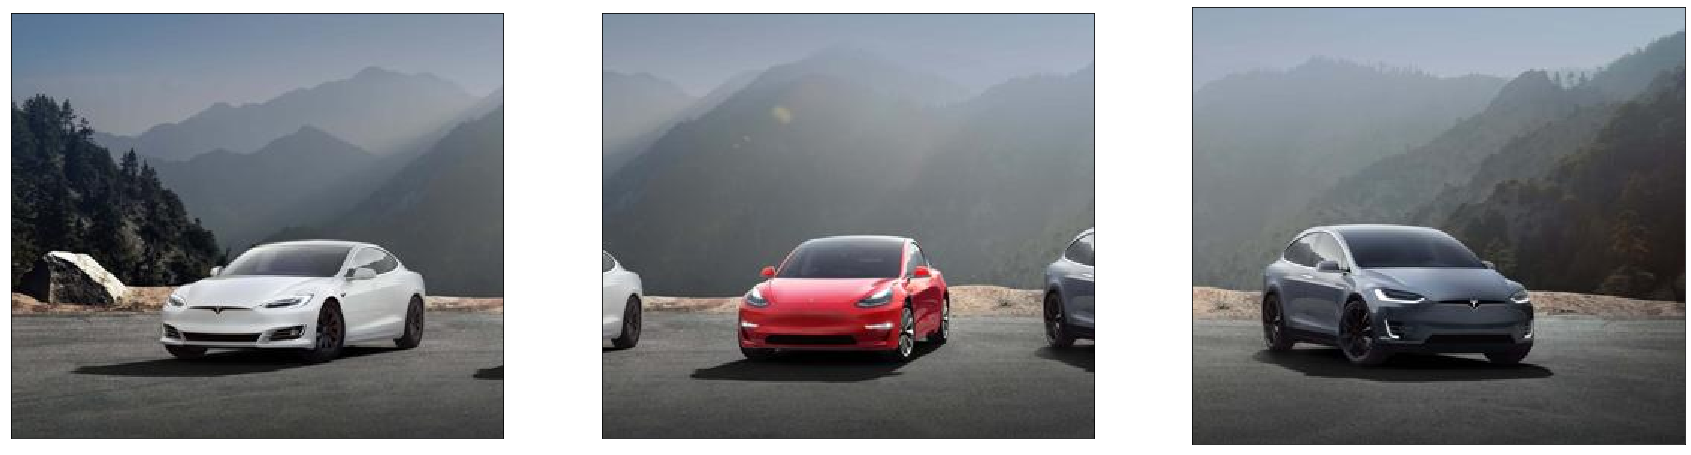

In [7]:
# Testing

# Load image and convert to RGB
image = cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB)

def test_image(image, mean_feat_val, stride_val, window_Size, thresh):
    detect_result = []
    
    # Extracting overlapping windows from the test image
    for i in range(0, image.shape[0], stride_val):
        for j in range(0, image.shape[1], stride_val):
            window = image[i:i + window_Size[1], j:j + window_Size[0]]
             
            # Resize
            resize_window = cv2.resize(window, (128,128))
            feature_map = hog([resize_window])
            
            # Compute euclidean distance
            euc_dist1 = np.linalg.norm(feature_map - mean_feat_val)
            euc_dist2 = np.linalg.norm(feature_map - mean_feat_val_flip)        
            
            # Thresholding distance
            if(euc_dist1 < thresh) and (euc_dist2 < thresh):
                detect_result.append(((i,j), window))
     
    # Sort results           
    detect_result = sorted(detect_result)
    
    # Display result
    plt.figure(figsize = (30,30))
    for i in range(3):
        plt.subplot(231 + i)
        plt.imshow(detect_result[i][1]),
        plt.xticks([]), plt.yticks([])
    plt.show()

# Finding accuracy    
test_image(image, mean_feat_val, 250, (330, 330), 700)

   